In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sc
from scipy.optimize import minimize
from scipy.special import gamma

# np.seterr('raise')
#%matplotlib
# %matplotlib notebook

N points with $\{L_i\}$, $X_0 = 1$ en cada iteración $X_i -> 1/N$

1- N points Uniform distributed en N-sphere. 

instead $ log L = log L_{max} - 0.5(x- \mu)^T \Sigma^{-1} (x-\mu)$, use:

   $ log L = log L_{max} - \alpha_d X^{2/d}$ 
   
   where $L_{max}$ and $X$ are unknown. 
   
   where d is the dimensionallity



In [19]:
def samplePoint(dims):    
    u = np.random.normal(0, 1, dims)  
    norm = np.sum(u**2)**0.5
    r = np.random.random()**(1.0/dims)
    x = r*u/norm
    return x

def samplingNSphere(npoints, dims):
    return np.array([samplePoint(dims) for i in range(npoints)])

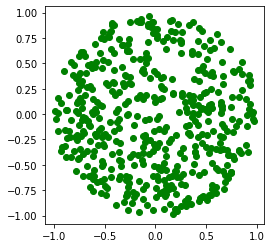

In [20]:
points2d = samplingNSphere(500, 2)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(points2d[:,0], points2d[:,1], c='g')
ax.set_aspect('equal', 'box')

(1000, 3)


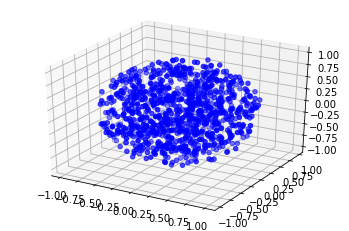

In [21]:
points3d = samplingNSphere(1000, 3)
print(points3d.shape)
fig = plt.figure()
# ax = fig.add_subplot(111,projection='3d')
ax = fig.gca(projection='3d')
ax.scatter(points3d[:,0], points3d[:,1], points3d[:, 2], c='b')

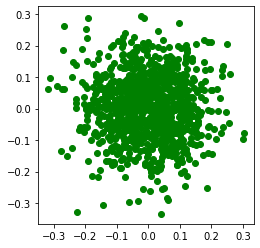

In [22]:
points4d = samplingNSphere(1000, 100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(points4d[:,0], points4d[:,1], c='g')
ax.set_aspect('equal')
# ax = fig.add_subplot(111)
# ax.scatter(points4d[:,2], points4d[:,3], c='r')
# ax.set_aspect('equal')


- Define a spherical Likelihood:
  $logL = -\frac{x^2}{2\sigma^2}$


In [23]:
sigma = 0.5
def sphereVolume(x):
#     return -x**2/2/sigma**2
    return 4/3*np.pi*np.sum(x**2)**(3/2)

def volNsphere(r, n):
    m = n / 2 + 1
    return r**n * (np.power(np.pi, n/2) / gamma(m))

def sphereLoglike(x):
#     return -x**2/2/sigma**2
    return -np.sum(x**2)/2/sigma**2

propossal fn: $log L = log L_{max} - \alpha_d X^{2/d}$

In [95]:
def propossalfn(x, logLmax, alpha, d=3):
    return logLmax - alpha*sphereVolume(x)**(2/d)

In [96]:
def logLike(theta, points):
    loglmax, alpha = theta
    sigma = 0.5
    chisq = np.sum(((likes - propossalfn(points, loglmax, alpha))/sigma)**2)
    return 0.5*chisq

Following plots must have the form : $log L = log L_{max} - \alpha_d X^{2/d}$

### 2D

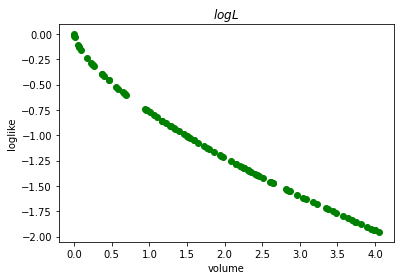

In [80]:
npoints = 100
points2d = samplingNSphere(npoints, 2)
likes2d = np.zeros((npoints, 1))

for i, p in enumerate(points2d):
    likes2d[i] = sphereLoglike(p)
    
volumes2d = np.zeros((npoints, 1))

for i, p in enumerate(points2d):
    volumes2d[i] = sphereVolume(p)
    
plt.scatter(volumes2d, likes2d, c='g')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()

### 3D

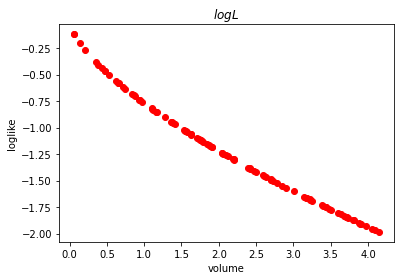

In [81]:
npoints = 100
points3d = samplingNSphere(npoints, 3)
likes3d = np.zeros((npoints, 1))

for i, p in enumerate(points3d):
    likes3d[i] = sphereLoglike(p)
    
volumes3d = np.zeros((npoints, 1))

for i, p in enumerate(points3d):
    volumes3d[i] = sphereVolume(p)
    
plt.scatter(volumes3d, likes3d, c='r')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()    

In [82]:
# saving samples
samples = np.concatenate([points3d, likes], axis=1)
idx = 10
print(points3d[idx], likes[idx])
samples[idx]

[-0.32065788 -0.5743953  -0.72194867] [0.]


array([-0.32065788, -0.5743953 , -0.72194867,  0.        ])

Trying to minimize given -loglike and proposal function:

In [83]:
X_max3d = np.max(volumes3d)
tmp_max_logl3d = np.max(likes3d)
print("Current max logl: {}".format(tmp_max_logl3d))
op = minimize(logLike,  [tmp_max_logl3d, 0.01], points3d)
print("Max like: {}, max alpha: {}".format(op.x[0], op.x[1]))

Current max logl: -0.11975998369880256
Max like: -0.11969216572205367, max alpha: -0.0007547677738751566


### 4D

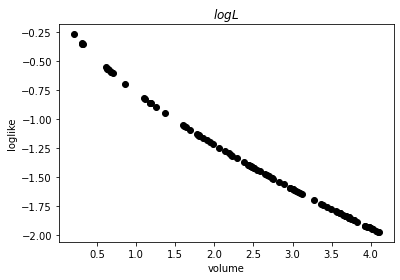

In [84]:
npoints = 100
points4d = samplingNSphere(npoints, 4)
likes4d = np.zeros((npoints, 1))

for i, p in enumerate(points4d):
    likes4d[i] = sphereLoglike(p)
    
volumes4d = np.zeros((npoints, 1))

for i, p in enumerate(points4d):
    volumes4d[i] = sphereVolume(p)
    
plt.scatter(volumes4d, likes4d, c='k')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()
    

In [66]:
X_max4d = np.max(volumes4d)
tmp_max_logl4d = np.max(likes4d)
print("Current max logl: {}".format(tmp_max_logl4d))
op = minimize(logLike,  [tmp_max_logl4d, 0.01], points4d)
print("Max like: {}, max alpha: {}".format(op.x[0], op.x[1]))
# alpha->op.x[1]


Current max logl: -0.35341960886923973
Max like: -0.3533492549265063, max alpha: -0.0020611335651650256


### 4D

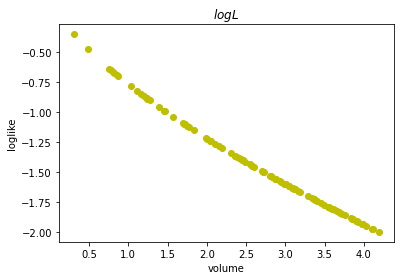

In [52]:
npoints = 100
points5d = samplingNSphere(npoints, 5)
likes5d = np.zeros((npoints, 1))

for i, p in enumerate(points5d):
    likes5d[i] = sphereLoglike(p)
    
volumes5d = np.zeros((npoints, 1))

for i, p in enumerate(points5d):
    volumes5d[i] = sphereVolume(p)
    
plt.scatter(volumes5d, likes5d, c='y')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()